In [1]:
import os
import docx
import PyPDF2
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


C:\Users\VidyaDinkar\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
RESUME_FOLDER = r"C:\Users\VidyaDinkar\Resume_Matcher_Project\resume_reader\resumes"

In [16]:
def read_docx(file_path):
    doc = docx.Document(file_path)
    return " ".join([para.text for para in doc.paragraphs])

In [18]:

# Function to read text from a PDF file
def read_pdf(file_path):
    text = ""
    with open(file_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() or ""
    return text

# Function to read any file (PDF, DOCX, TXT)
def read_resume(file_path):
    if file_path.endswith(".docx"):
        return read_docx(file_path)
    elif file_path.endswith(".pdf"):
        return read_pdf(file_path)
    elif file_path.endswith(".txt"):
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            return f.read()
    else:
        return ""

# ✅ Step 1: Load resumes
resumes = {}
for file_name in os.listdir(RESUME_FOLDER):
    file_path = os.path.join(RESUME_FOLDER, file_name)
    text = read_resume(file_path)
    if text.strip():
        resumes[file_name] = text

In [19]:
def extract_text_from_pdf(file_path):
    text = ""
    with open(file_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            if page.extract_text():
                text += page.extract_text() + " "
    return text.strip()

def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    return " ".join([para.text for para in doc.paragraphs]).strip()

def load_resume(file_path):
    if file_path.endswith(".pdf"):
        return extract_text_from_pdf(file_path)
    elif file_path.endswith(".docx"):
        return extract_text_from_docx(file_path)
    else:
        return None

In [20]:
job_description_text = """
Machine Learning Engineer
Responsibilities:
•	Develop and deploy ML models for predictive analytics.
•	Preprocess and clean large datasets.
•	Optimize algorithms for scalability and performance.
•	Integrate ML solutions into applications.
•	Stay updated with latest AI/ML advancements.
Requirements:
•	Strong skills in Python, TensorFlow, PyTorch, or Scikit-learn.
•	Experience with data pipelines and cloud ML services.
•	Solid understanding of statistics and algorithms.
•	Ability to work in a fast-paced environment.
"""
print("📄 Job Description Loaded.")

📄 Job Description Loaded.


In [21]:
skills = [
    "Python", "SQL", "Excel", "Power BI", "Tableau",
    "Data Analysis", "Machine Learning", "Statistics",
    "Communication", "Problem Solving"
]


In [22]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [23]:
job_description_embedding = model.encode(job_description_text)

In [24]:
resume_embeddings = {}
for file_name, resume_text in resumes.items():
    if resume_text:
        resume_embeddings[file_name] = model.encode(resume_text)

In [26]:
similarity_scores = {}
for file_name, resume_embedding in resume_embeddings.items():
    score = cosine_similarity(
        [job_description_embedding],
        [resume_embedding]
    )[0][0]
    similarity_scores[file_name] = round(score * 100, 2)

In [27]:
def analyze_skills(resume_text, skills):
    matched = []
    missing = []
    text_lower = resume_text.lower()
    for skill in skills:
        if skill.lower() in text_lower:
            matched.append(skill)
        else:
            missing.append(skill)
    return matched, missing

In [28]:
print("\n Ranked Resumes with Skill Match Analysis:\n")
ranked_resumes = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)
for i, (file_name, score) in enumerate(ranked_resumes):
    resume_text = resumes[file_name]
    matched, missing = analyze_skills(resume_text, skills)

    print(f"Rank {i+1}: {file_name}")
    print(f"   🔹 Match Score: {score}%")
    print(f"   ✅ Matched Skills: {', '.join(matched) if matched else 'None'}")
    print(f"   ❌ Missing Skills: {', '.join(missing) if missing else 'None'}\n")


 Ranked Resumes with Skill Match Analysis:

Rank 1: Resume27vid.docx
   🔹 Match Score: 57.40999984741211%
   ✅ Matched Skills: Python, SQL, Data Analysis, Machine Learning
   ❌ Missing Skills: Excel, Power BI, Tableau, Statistics, Communication, Problem Solving

Rank 2: Vidya_Dinkar_Resume2025.pdf
   🔹 Match Score: 51.650001525878906%
   ✅ Matched Skills: Python, SQL, Data Analysis, Machine Learning
   ❌ Missing Skills: Excel, Power BI, Tableau, Statistics, Communication, Problem Solving

Rank 3: Piyush_Patel_Resume.pdf
   🔹 Match Score: 41.18000030517578%
   ✅ Matched Skills: Python, SQL, Machine Learning, Problem Solving
   ❌ Missing Skills: Excel, Power BI, Tableau, Data Analysis, Statistics, Communication



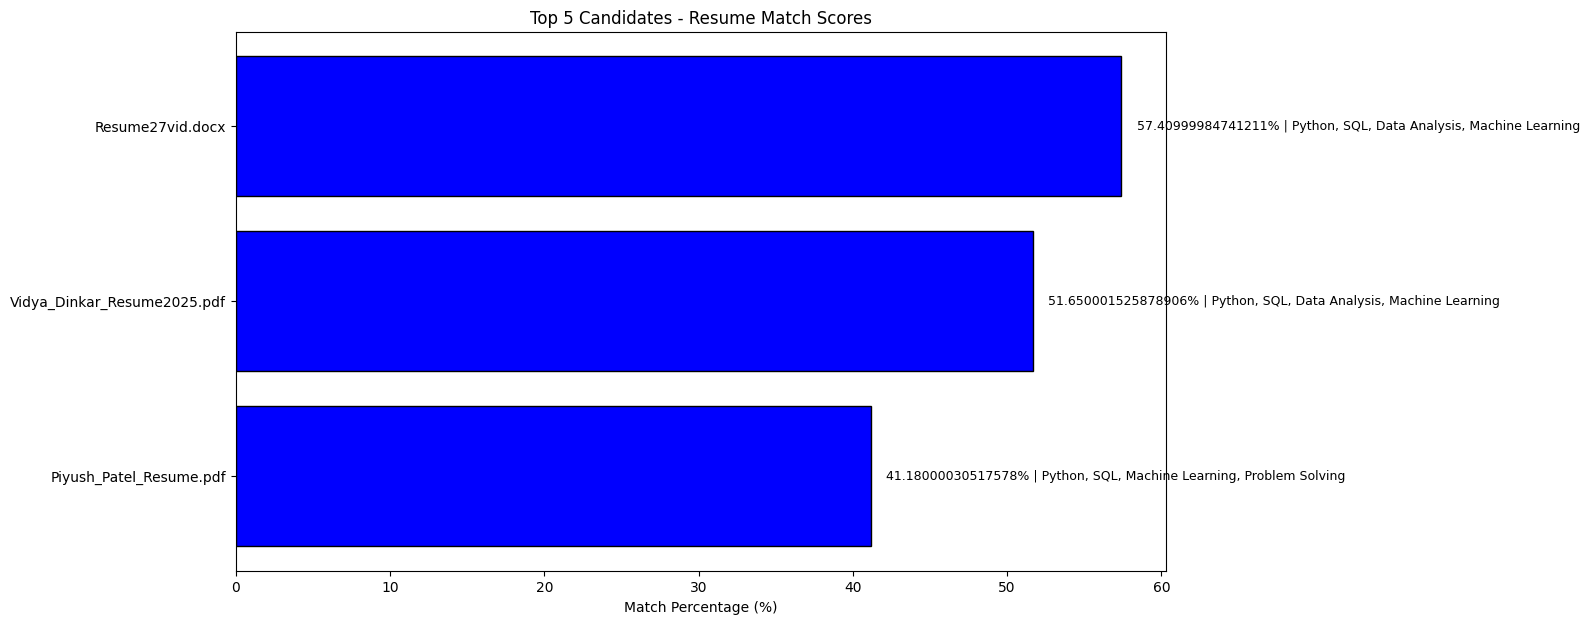

In [29]:
top_n = 5
top_resumes = ranked_resumes[:top_n]

names = []
scores = []
skills_summary = []

for file_name, score in top_resumes:
    resume_text = resumes[file_name]
    matched, missing = analyze_skills(resume_text, skills)
    names.append(file_name)
    scores.append(score)
    skills_summary.append(", ".join(matched) if matched else "No Skills Matched")

#Bar Chart
plt.figure(figsize=(12,7))
bars = plt.barh(names, scores, color="blue", edgecolor="black")

plt.xlabel("Match Percentage (%)")
plt.title(f"Top {top_n} Candidates - Resume Match Scores")


for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f"{scores[i]}% | {skills_summary[i]}",
             va="center", fontsize=9, color="black")

plt.gca().invert_yaxis()
plt.show()


